In [9]:
class CustomError(Exception):
    def __init__(self, *args):
        super().__init__(*args)

In [1]:
import torch
from transformers import AutoTokenizer
from dotenv import load_dotenv
import os

class LLMInterface:
    def __init__(
            self,
            model_name: str,
            device: str = "cuda:0" if torch.cuda.is_available() else "cpu"):
        
        self.device = device
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_auth_token = os.getenv('HF_ACCESS_TOKEN'))

    def preprocesser_inference(
            self,
            input: list[str],
            pad: bool,
            truncate: bool,
            max_length: int,
            return_tensor: str = "pt"
    ):
        tokenized_text = []
        for text in input:
            tk_txt = self.tokenizer(text, max_length=max_length,padding=pad, truncation=truncate, return_tensors=return_tensor).to(self.device)
            tokenized_text.append(tk_txt)
        return tokenized_text
    
class classifierInterface(LLMInterface):
    def __init__(self, model_name: str, id2label: dict, label2id: dict, num_labels=2, device = "cuda:0" if torch.cuda.is_available() else "cpu"):
        super().__init__(model_name, device)
        load_dotenv()
        from transformers import AutoModelForSequenceClassification
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16 if self.device=="cuda:0" else torch.float32,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
            token = os.getenv('HF_ACCESS_TOKEN')
        ).to(self.device)

    def inference_classify(
            self,
            inputs: list[str],
            pad: bool,
            truncate: bool,
            max_length: int,
            return_tensor: str = "pt"
    ):
        classes = []
        inputs = self.preprocesser_inference(inputs, pad, truncate, max_length, return_tensor)
        for input in inputs:
            with torch.no_grad():
                input = {key: value.to(self.device) for key, value in input.items()}
                logits = self.model(**input).logits
            predicted_class = logits.argmax().item()
            classes.append(self.model.config.id2label[predicted_class])
        return classes
    
class extractorInterface(LLMInterface):
    def __init__(self, model_name: str, device: str = 'cuda:0' if torch.cuda.is_available() else "cpu"):
        super().__init__(model_name, device)
        from transformers import AutoModelForTokenClassification
        self.model = AutoModelForTokenClassification.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16 if self.device=="cuda" else torch.float32,
            token = os.getenv('HF_ACCESS_TOKEN')
        )
    
    def inference_extract(
            self,
            input: str,
            pad: bool,
            truncate: bool,
            max_length: bool,
            return_tensor: str = "pt"
    ):
        input = self.preprocesser_inference(input, pad, truncate, max_length, return_tensor)
        with torch.no_grad():
            logits = self.model(**input).logits
        
        # TODO: RETURN THE APPROPRIATE VALUE, NOT LOGITS, FROM HERE

/home/tadesa1/ADBMO-UNLV/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if __name__ == "__main__":
    
    model_names = ["meta-llama/Llama-3.1-8B", "meta-llama/Llama-3.1-40B","meta-llama/Llama-3.2-1B"]
    
    id2label = {
        0: 'IRRELEVANT',
        1: 'RELEVANT'        
    }

    label2id = {
        'IRRELEVANT': 0,
        'RELEVANT': 1        
    }
    classifier = classifierInterface(model_name=model_names[2], id2label=id2label, label2id=label2id)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preparing Data for training and testing

In [37]:
import json
from datasets import Dataset

with open('/home/tadesa1/ADBMO-UNLV/SentrySys_Experiments/classification_results_openai.json', 'r') as f:
    classified_results = json.load(f)

del classified_results['---']

def data_generator():
    for obj in classified_results:
        try:
            yield {"pmid": obj, "true_class": classified_results[obj]['class'], "title":classified_results[obj]['title'], "abstract": classified_results[obj]['summary']['Abstract'], "method": classified_results[obj]['summary']['Method'], "predicted_class": 0 if classified_results[obj]['openai_response'] == 'No' else 1}
        except KeyError:
            yield {"pmid": obj, "true_class": 0 if classified_results[obj]['openai_response'] == 'No' else 1, "title":classified_results[obj]['title'], "abstract": classified_results[obj]['summary']['Abstract'], "method": classified_results[obj]['summary']['Method'], "predicted_class": 0 if classified_results[obj]['openai_response'] == 'No' else 1}

data = Dataset.from_generator(data_generator)
false_class_data = data.filter(lambda e: e['true_class'] == 0)
true_class_data = data.filter(lambda e: e['true_class'] == 1)

### Attempting a classification 

In [38]:
test_data = []
for paper in data:
    test_data.append([paper['title']+paper['abstract']+paper['method']])

In [56]:
result = []
for paper in data:
    test_data = [paper['title']+paper['abstract']+paper['method']]
    result.append(classifier.inference_classify(inputs=test_data, pad = False, truncate = False, max_length=4096))
    # print(f"{result} : {paper['predicted_class']}")

In [61]:
print(result[0][0])

IRRELEVANT


<class 'list'>
<class 'list'>


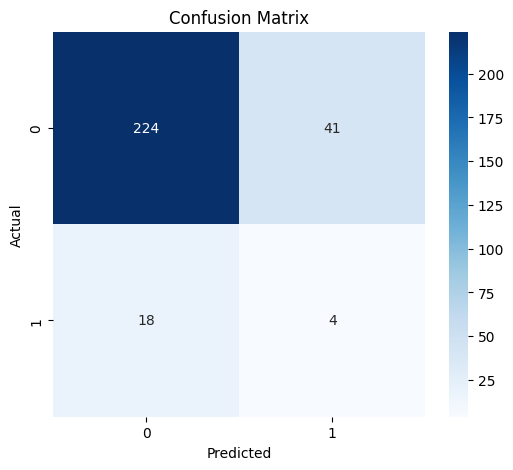

              precision    recall  f1-score   support

           0       0.93      0.85      0.88       265
           1       0.09      0.18      0.12        22

    accuracy                           0.79       287
   macro avg       0.51      0.51      0.50       287
weighted avg       0.86      0.79      0.83       287



In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

predicted_labels = []
true_labels = []

true_labels = [example['true_class'] for example in data]
# predicted_labels = [print(example[0]) for example in result]
predicted_labels = [1 if res[0] == 'RELEVANT' else 0 for res in result]


print(type(true_labels))
print(type(predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
 
# Print classification report
print(classification_report(true_labels, predicted_labels))


# Question

* Will performance improve in all aspects if we perform unsupervised fine tuning on the models?

The goal is to have a general purpose ADBMO model that we can recycle for different purposes. A chatbot with reasoning capabilities, text extraction and classification, and even document searching abilities.
- Let's start off by training adapters that we can plugin to existing models. Let's measure the performance of that for our downstream tasks like text extraction and classification and then see if further fine-tuning is necessary.